In [1]:
from common import *
%matplotlib inline
canvas(9, 9)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/pandas/core/common.py:701: RuntimeWarning: divide by zero encountered in log
  return func(obj, *args, **kwargs)


##### Goals:
- find typical and atypical values for x
    - possibly depends on y or weight
- find appropriate per stock or per day normalizations of x
- when normalized across stock / day, find relationship with y
- (misc small things)
    - differentiate, if can, between df and dg
    - attempt a statistical model

In [67]:
def box(a, scale=(1 << 20)):
    return np.round(a * scale) / scale

In [79]:
values = dh.x6.pipe(box).value_counts()
[print(i, line) for i, line in enumerate(values.items()) if i < 308]
lim = 299

0 (100.0, 609743)
1 (200.0, 31848)
2 (150.0, 14908)
3 (300.0, 8527)
4 (120.0, 5768)
5 (110.0, 5036)
6 (140.0, 4532)
7 (250.0, 4508)
8 (400.0, 4362)
9 (130.0, 3777)
10 (500.0, 3724)
11 (180.0, 3416)
12 (160.0, 3298)
13 (1000.0, 2932)
14 (190.0, 2911)
15 (220.0, 2842)
16 (170.0, 2755)
17 (240.0, 2685)
18 (260.0, 2583)
19 (280.0, 2476)
20 (230.0, 2397)
21 (210.0, 2384)
22 (350.0, 2268)
23 (270.0, 2079)
24 (1200.0, 2012)
25 (290.0, 1954)
26 (1100.0, 1857)
27 (320.0, 1793)
28 (360.0, 1743)
29 (310.0, 1706)
30 (50.0, 1643)
31 (1500.0, 1614)
32 (340.0, 1600)
33 (330.0, 1577)
34 (380.0, 1513)
35 (600.0, 1460)
36 (1300.0, 1416)
37 (370.0, 1286)
38 (450.0, 1246)
39 (390.0, 1236)
40 (2000.0, 1151)
41 (410.0, 1141)
42 (440.0, 1112)
43 (420.0, 1100)
44 (1400.0, 1090)
45 (10.0, 1073)
46 (460.0, 979)
47 (430.0, 971)
48 (480.0, 958)
49 (470.0, 885)
50 (700.0, 883)
51 (800.0, 846)
52 (40.0, 825)
53 (1600.0, 816)
54 (60.0, 790)
55 (520.0, 780)
56 (550.0, 778)
57 (490.0, 762)
58 (20.0, 752)
59 (5000.0, 7

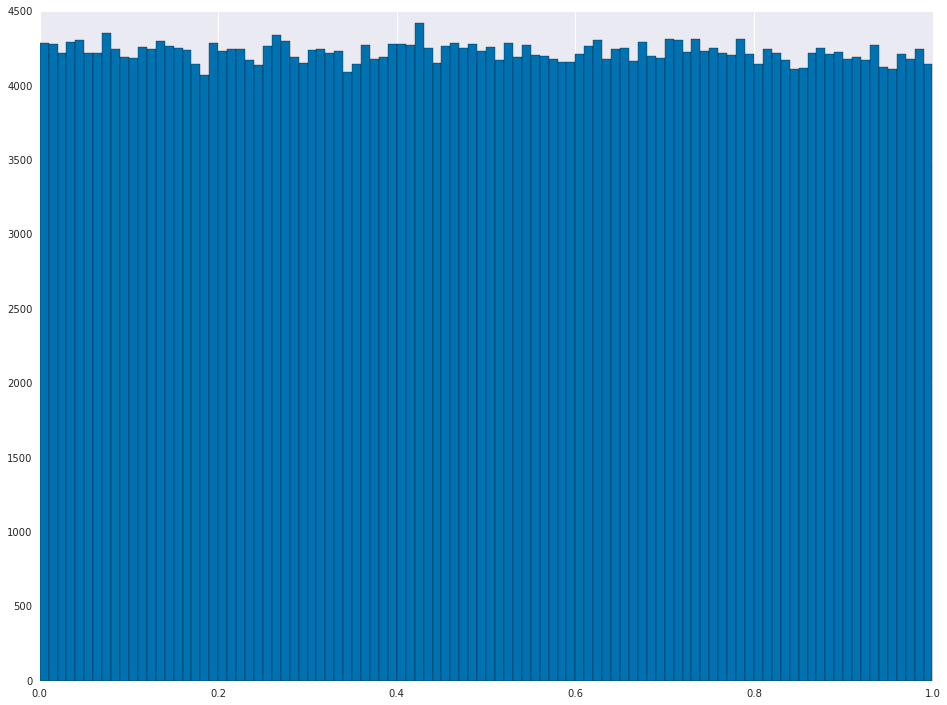

In [123]:
frac, whol = np.modf(dh.x6)
fracf = frac[(np.abs(frac - 0) > 1e-6) & (np.abs(frac - 1) > 1e-6)]
fracf.hist(bins=100);

### square bubble plots

In [2]:
from scipy.stats import boxcox_normplot, boxcox

In [3]:
X = dh[xfeats].pipe(makesw)
Xpmin = X.replace(0, 1e100).min() * (X == 0).astype(np.int)

In [ ]:
A, B, F = -5, 5, 16 * 16
ll = np.arange(A, B + 1e-6, 1 / F)
L = len(ll)
errors = []
def boxcoxprob(a):
    from scipy.stats import boxcox_normplot, boxcox
    try:
        return boxcox_normplot(a[~np.isnan(a)], A, B, N=L)[1]
    except Exception:
        return np.empty((L,)) + np.nan
xwide = X + Xpmin / 2

In [ ]:
res = [None] * len(list(xwide))
for i, col in list(enumerate(xwide))[:]:
    print('.' if i % 10 else i, end='')
    a = xwide[col].values
    res[i] = boxcoxprob(a)
thing = np.stack(res, axis=1)
np.save(top_dir + 'data/progress/boxcoxprob256.npy', thing)
bcp = pd.DataFrame(thing, columns=xwide.columns)
bcp.index = pd.Series(ll, name='Lambda')

0.........10.........20.........30.........40.........50.........60.........70.........80.........90.........100.........110.........120.........130.........140.........150.........160.........170.........180.........190.........200.........210.........220.........230.........240.........250.........260.........270.........280.........290.........300.........310.........320.........330.........340.........350.........360.........370.........380.........390.........400.........410.........420.........430.........440.........450.........460.........470.........480.........490.........500.........510.........520.........530.........540.........550.........560.........570.........580.........590.........600.........610.........620.........630.........640.........650.........660.........670.........680.........690.........700.........710.........720.........730.........740.........750.........760.........770.........780.........790.........800.........810.........820.........830.........840

In [12]:
sfilt = dh.groupby('Stock').apply(lambda x: all((x[f] != 0).all() for f in xfeats))

In [13]:
thefilt = sfilt & stock_nvdf(dh, 246)
print(thefilt.sum())
bcpf = bcp.wide_filter(thefilt)

1926


In [14]:
agg = bcpf.pipe(np.log).mean(level=0, axis=1).pipe(np.exp)

nan


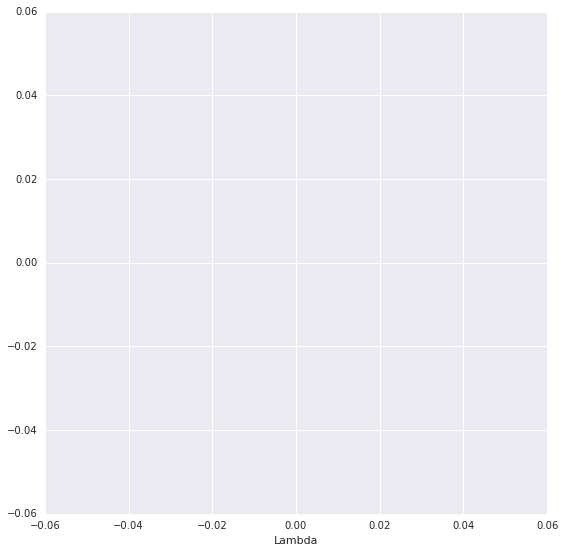

In [16]:
_f = 'x6'
lmax = agg[_f].idxmax()
print(lmax)
agg[_f].plot();
plt.axvline(lmax, color='r');
#plt.xlim(-1, 1);
#plt.ylim(.5, 1);

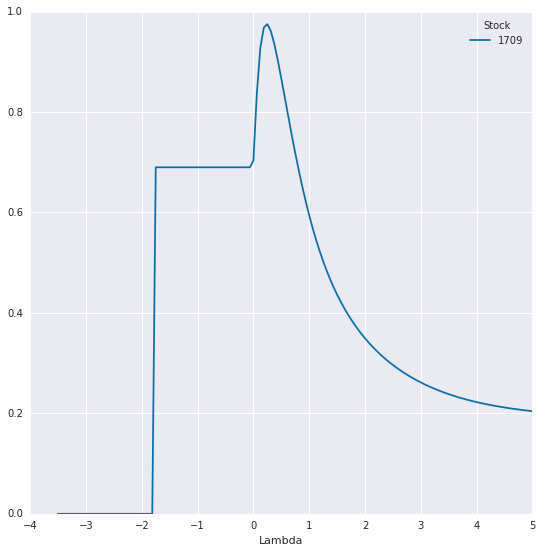

In [249]:
bcp.loc[:, (ss, 1709)].x0.plot();

In [ ]:
raise Stop

-1.2973281534


160

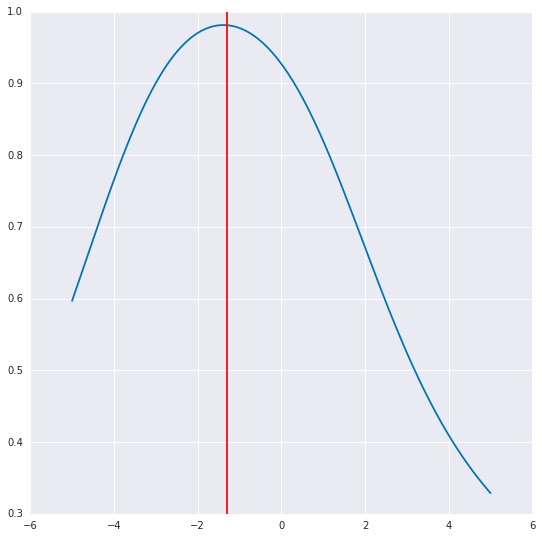

In [213]:
from scipy.stats import boxcox_normplot, boxcox
x = dh[dh.Stock == np.random.choice(stock_nvdf(dh, 246).nonzero()[0])].x2
#x = 1 / ((np.random.randn(500) + 5) ** 1)
prob = boxcox_normplot(x, -5, 5, N=160);
plt.plot(prob[0], prob[1]);
y, maxlog = boxcox(x)
plt.axvline(maxlog, color='r')
print(maxlog)
len(prob[0])

In [40]:
def _p(x):
    try:
        return boxcox(x[~x.isna()])[1]
    except Exception:
        return np.nan
lmb = dh.groupby('Stock').agg(_p)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:901: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/home/ec2-user/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2189: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/ec2-user/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1849: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/home/ec2-user/anaconda3/lib/python3.6/site-packages/scipy/optimiz

In [128]:
lmb[stock_nvdf(dh, 246)][xfeats].mean()

x0    -0.022320
x1    -0.590900
x2    -0.623572
x3A    2.090407
x3B    2.393793
x3C    2.600112
x3D    2.828935
x3E    3.069032
x4    -0.463615
x5     0.410676
x6     0.150604
dtype: float64

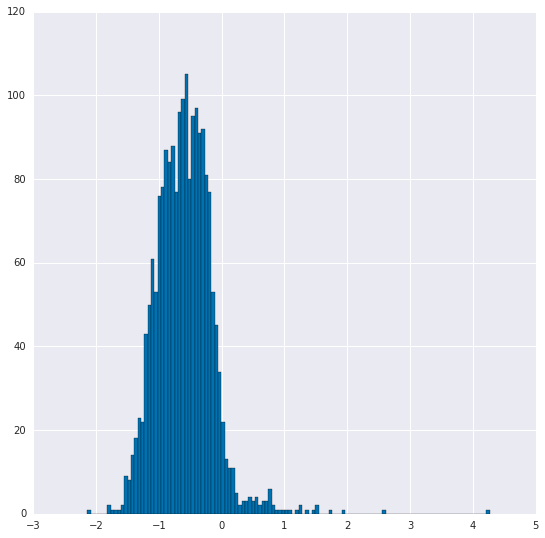

In [61]:
lmb[stock_nvdf(dh, 246)].x1.clip(-10, 10).hist(bins=120);

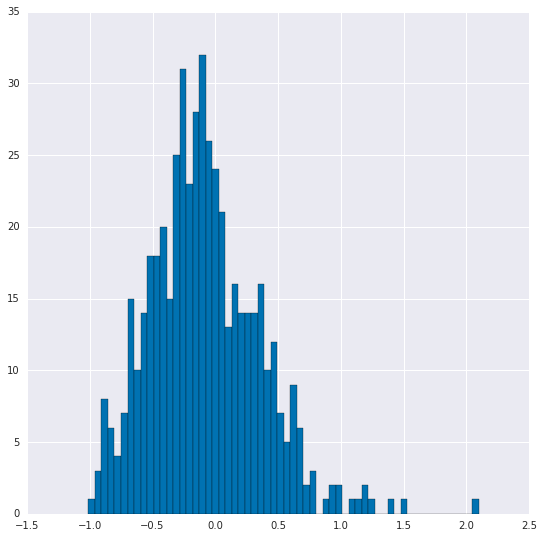

In [74]:
dh[dh.Stock == 1000].x1.pipe(np.log).hist(bins=60);

In [283]:
from scipy.stats import norm

In [341]:
Xlog = dh[x_feats + x3feats + ['x3', 'x3l']].pipe(np.log).pipe(makesw)
Xplog = Xlog.replace(-np.inf, np.nan)
Xplogs = Xplog.pipe(_standardize).replace(-np.inf, np.nan).replace(np.inf, np.nan)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/pandas/core/common.py:701: RuntimeWarning: divide by zero encountered in log
  return func(obj, *args, **kwargs)


In [357]:
_standardize

<function __main__.<lambda>>

In [366]:
Xlog.x6[262].value_counts()

4.60517    191
4.60517     50
4.60517      7
4.60517      3
Name: 262, dtype: int64

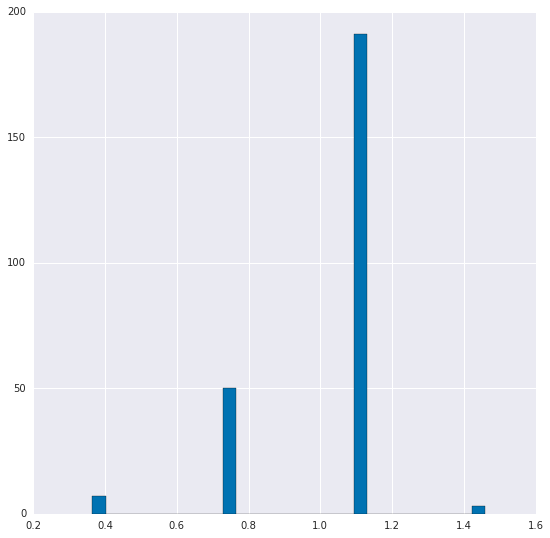

In [364]:
Xplogs.x6[262].hist(bins=30);

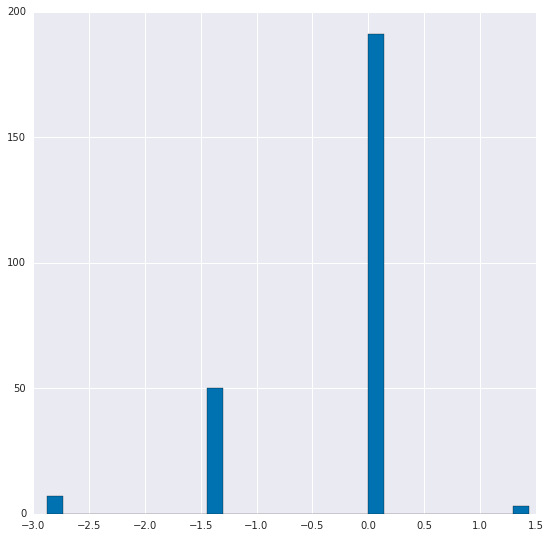

In [363]:
Xplog.x6[262].pipe(lambda X: (X - X.wmean(Wa[262])) / np.sqrt(X.wvar(Wa[262]))).hist(bins=30);

In [353]:
(Xplogs.min() > 0).idxmax()

('x6', 262)

In [350]:
1e-20 ** .5

1e-10

In [305]:
Xplogs.min().idxmin()

('x0', 139)

In [337]:
Xplogs.max().idxmax()

('x1', 1755)

###### w and y

In [251]:
W = dh.Weight.pipe(makesw)
Wnrm = W.pipe(lambda w: w / w.sum())
Wa = W.fillna(0)
Wnrma = Wnrm.fillna(0)
_standardize = lambda X: (X - X.wmean(Wa)) / np.sqrt(X.wvar(Wa))
Y = dh.y.pipe(makesw)
Ystd = Y.pipe(_standardize)
Ya = Y.fillna(0)
Ystda = Ystd.fillna(0)
_demean = lambda x: x - x.wmean(Wa)

In [252]:
y = Ystda._swfilter(sfilt).stack().rename('y')
w = Wnrma._swfilter(sfilt).stack().rename('w')

###### x

In [253]:
Xlogs = dh[x_feats + x3feats + ['x3l']].pipe(np.log).pipe(makesw).pipe(_standardize)
Xlogsa = Xlogs.fillna(0)
Xwpct = dh[x_feats + x3feats + ['x3l']].pipe(makesw).wpct(Wa)
Xwpcta = Xwpct.fillna(0.5)
Xwnrm = Xwpct.pipe(Xwpct)
Xwnrma = Xwnrm.fillna(0)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/pandas/core/common.py:701: RuntimeWarning: divide by zero encountered in log
  return func(obj, *args, **kwargs)
/home/ec2-user/Notebooks/g-research-ffc2018/helper/weighted.ipynb:11: RuntimeWarning: invalid value encountered in true_divide
  "from common import *"


TypeError: 'DataFrame' object is not callable

In [291]:
sfilt = stock_nvdf(dh, 246) # <===============
Xa = Xwnrma # <==============================
x = Xa._swfilter(sfilt).stack()

In [314]:
fine = 4
xbox = (np.floor(x * fine) + 0.5) / fine

###### go

In [320]:
f0, f1 = 'x0', 'x3'
data = pd.concat([xbox, y, w], axis=1).groupby([f0, f1]).apply(lambda v: v.y.wmean(v.w)).rename('_y_')
a0, a1, z = data.index.get_level_values(0), data.index.get_level_values(1), data.values

/home/ec2-user/Notebooks/g-research-ffc2018/helper/weighted.ipynb:6: RuntimeWarning: invalid value encountered in double_scalars
  "metadata": {


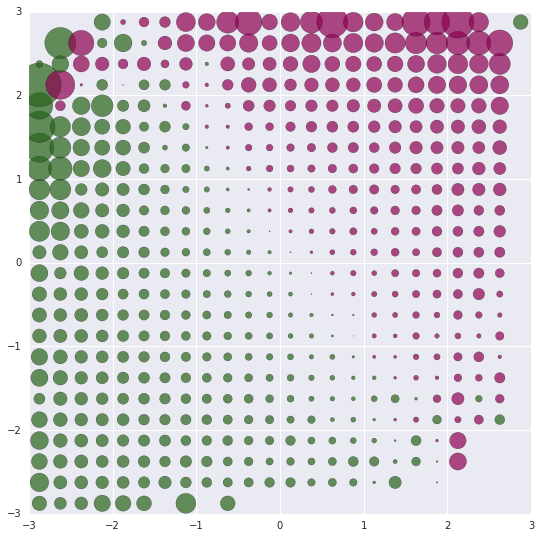

In [321]:
plt.scatter(a0, a1, s=np.abs(z) * 250, c=np.sign(z), cmap=plt.get_cmap('PiYG', 2), alpha=.7);
plt.xlim(-3, 3);
plt.ylim(-3, 3);

# legit stuffs:

In [2]:
from matrix import *
def_matrices(globals(), df)
Ypct = percentile_transform(Y)
Wpct = percentile_transform(W, positive=True)

In [3]:
MARKET = market[np.newaxis, :].repeat(Y.shape[0], axis=0) + Y.fillna(0) * 0
marketcmap = {1: 'gray', 2: 'blue', 3: 'green', 4: 'red'}
marketc = market.map(marketcmap)

## x explore particular

In [4]:
def fdisp(n):
    pd.options.display.float_format = ('{:,.' + str(n) + 'f}').format

In [58]:
xcol = 'x5'
scale = 1e6
d10 = int(np.log10(scale))
frac, whol = np.modf(dh[xcol] * scale)

0.089720059862689938    1
0.758516886055652817    1
0.141631785887349704    1
0.946758349137077904    1
0.203670876582765059    1
0.490909180610901441    1
0.433714912624656002    1
0.748677578896607243    1
0.747925755374728496    1
0.381784584768990354    1
0.529902789753031844    1
0.315289977130822852    1
0.373235510377969593    1
0.590625287085502437    1
0.587901601935983620    1
Name: x5, dtype: int64


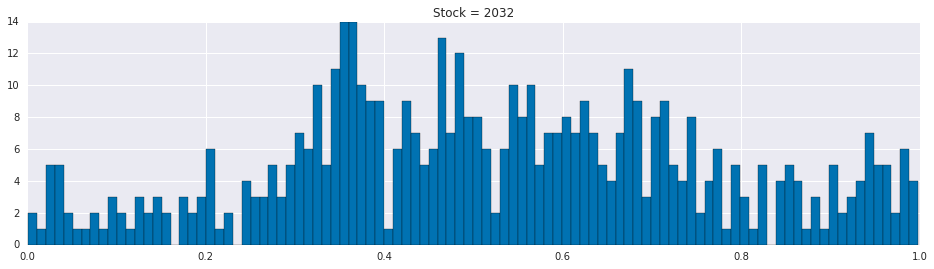

In [59]:
canvas(16, 4)
fdisp(18)
M = 2
S = random.sample(set(Y.columns[market == M]), 1)[0]
pts = frac[dh.Stock == S]
/print pts.value_counts().tail(15)
plt.hist(pts, bins=100);
plt.title('Stock = ' + str(S));

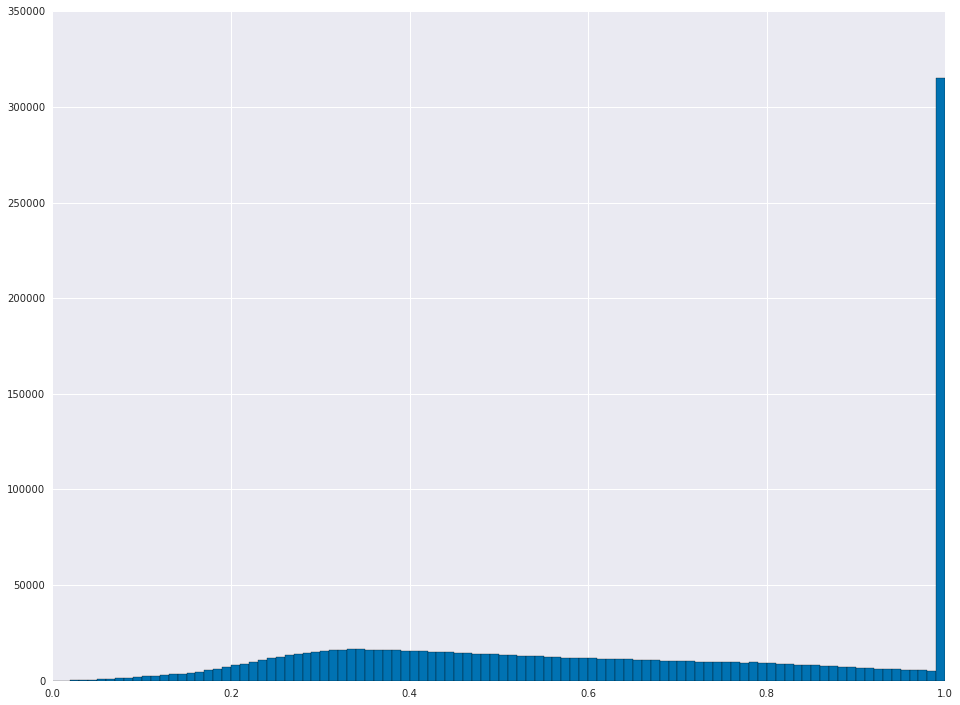

In [176]:
dh.x2.clip(0, 1).hist(bins=100);

In [182]:
# old; break
xcol = 'x2'
tab = dh[xcol].value_counts().reset_index()
tab.columns = [xcol, 'Count']
frac, whol = np.modf(dh[xcol] * 1e1)
tab['frac'] = frac
tab['whol'] = whol

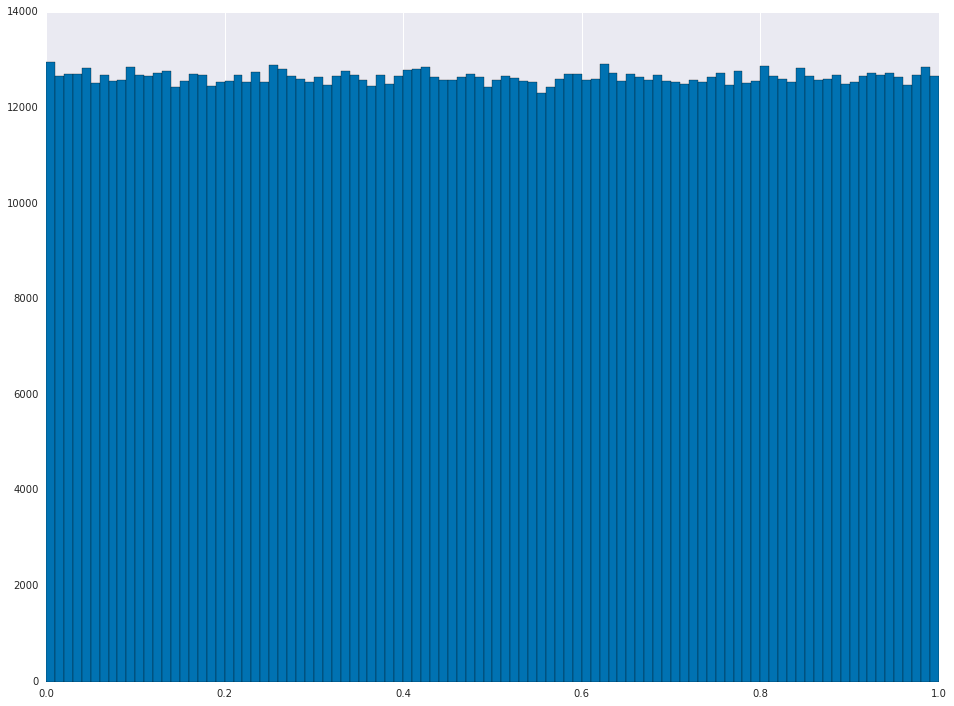

In [183]:
frac.hist(bins=100);

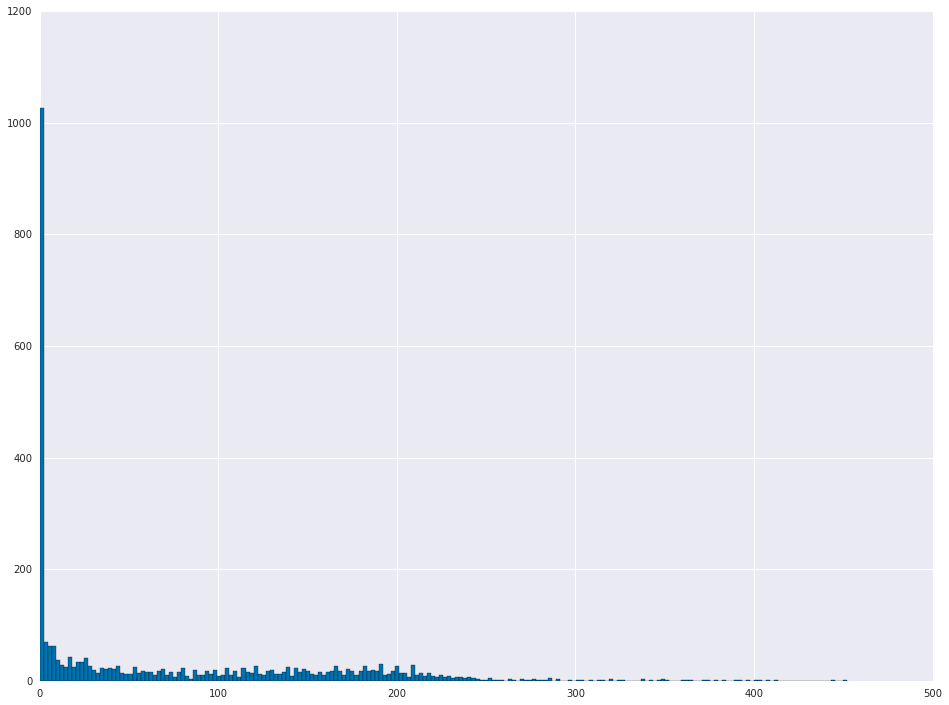

In [185]:
dh.groupby('Stock').x6.agg(lambda x: (x == 100).sum()).hist(bins=200);

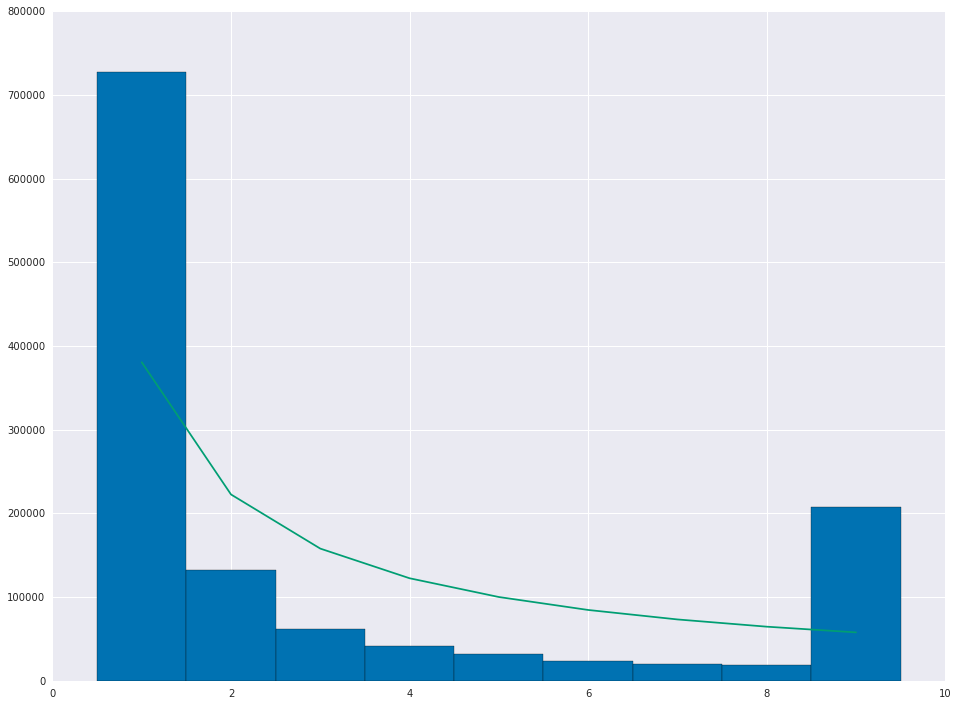

In [32]:
plot_benford(dh.x6);

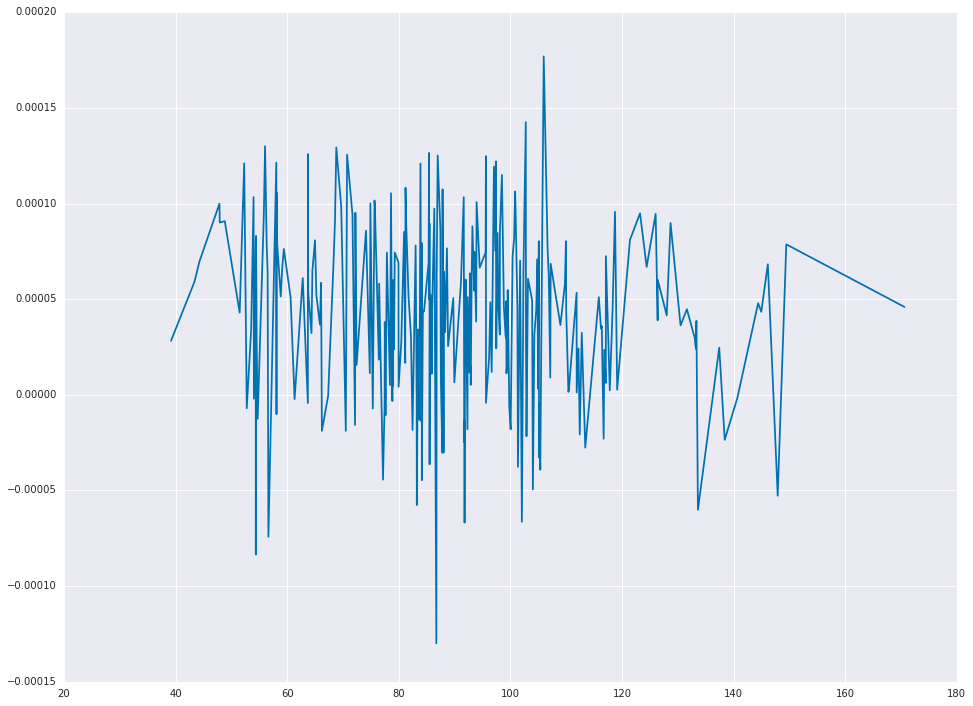

In [21]:
data = df[df.Stock == 109]
plt.plot(data.x.values_sort(), data.y.values_sort(data.x6 * data.x1));

# x y plots

In [94]:
mpl.colors.cnames['blueviolet']

'#8A2BE2'

In [95]:
mpl.colors.BASE_COLORS

{'b': (0, 0, 1),
 'c': (0, 0.75, 0.75),
 'g': (0, 0.5, 0),
 'k': (0, 0, 0),
 'm': (0.75, 0, 0.75),
 'r': (1, 0, 0),
 'w': (1, 1, 1),
 'y': (0.75, 0.75, 0)}

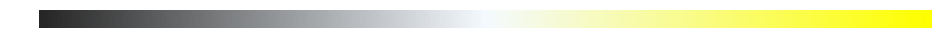

In [98]:
from matplotlib.colors import LinearSegmentedColormap as LSC
a = np.linspace(0, 1+1e-5, 256).reshape(1, -1)
divcmap = LSC.from_list('', [(.15, .15, .15), (.96, .98, 1), (1, 1, 0)])
canvas(16, 1)
plt.imshow(a, aspect=5, cmap=divcmap);
plt.axis('off')
plt.gca().grid(False)
canvas(16, 12)

In [99]:
X = df.pivot('Day', 'Stock', 'x4')
XX = df.pivot('Day', 'Stock', 'x6')

In [100]:
Xpct = percentile_transform(X, positive=True)
Xpctval = Xpct.values_sort()
XXpct = percentile_transform(XX, positive=True)
XXpctval = XXpct.values_sort(Xpct)
Wpctval = Wpct.values_sort(Xpct)
Ypctval = Ypct.values_sort(Xpct)
Yval = Y.values_sort(Xpct)

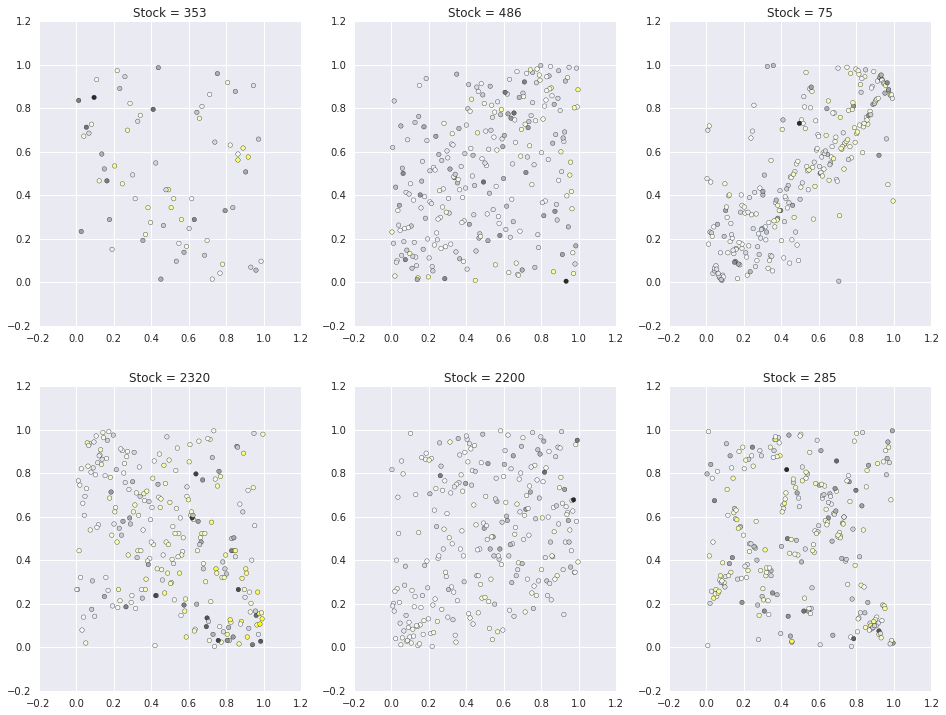

In [101]:
from matplotlib.colors import Normalize as cNormalize
C = O(N_SAMPLES=6, COL_WRAP=3, HEIGHT=235, WIDTH=235)
M = 2
samples = set(random.sample(set(Y.columns[market == M]), C.N_SAMPLES))
fig, axs = plt.subplots(2, 3)
for s, ax in zip(samples, axs.flatten()):
    f = lambda x: x.T[Y.columns == s].T
    ext = max(-f(Y).min().min(), f(Y).max().max())
    ax.scatter(f(Xpct), f(XXpct), alpha=0.99, c=f(Y),
               cmap=divcmap, norm=cNormalize(-ext, ext))
    ax.set_title('Stock = ' + str(s))
#plt.yscale('symlog', linthreshy=1e-35)
#plt.xscale('linear')

In [10]:
raise Stop()

Stop: 

In [ ]:
marketcmap = {1: 'gray', 2: 'blue', 3: 'green', 4: 'red'}
marketc = market.map(marketcmap)
#for M in [1, 2, 3, 4]:
plt.plot(Ypct, Xpct, alpha=0.01, c=defaultc);
#plt.yscale('symlog', linthreshy=1e-35)
#plt.xscale('linear')

C = O(N_SAMPLES=6, COL_WRAP=3, HEIGHT=235, WIDTH=235)
M = 2
samples = set(random.sample(set(Y.columns[market == M]), C.N_SAMPLES))
fig, axs = plt.subplots(2, 3)
for s, ax in zip(samples, axs.flatten()):
    filt = lambda x: x.T[Y.columns == s].T
    ax.plot(filt(Ypctval), filt(Xpctval), alpha=0.5, c=defaultc);
    ax.set_title('Stock = ' + str(s))
#
#plt.yscale('symlog', linthreshy=1e-35)
#plt.xscale('linear')

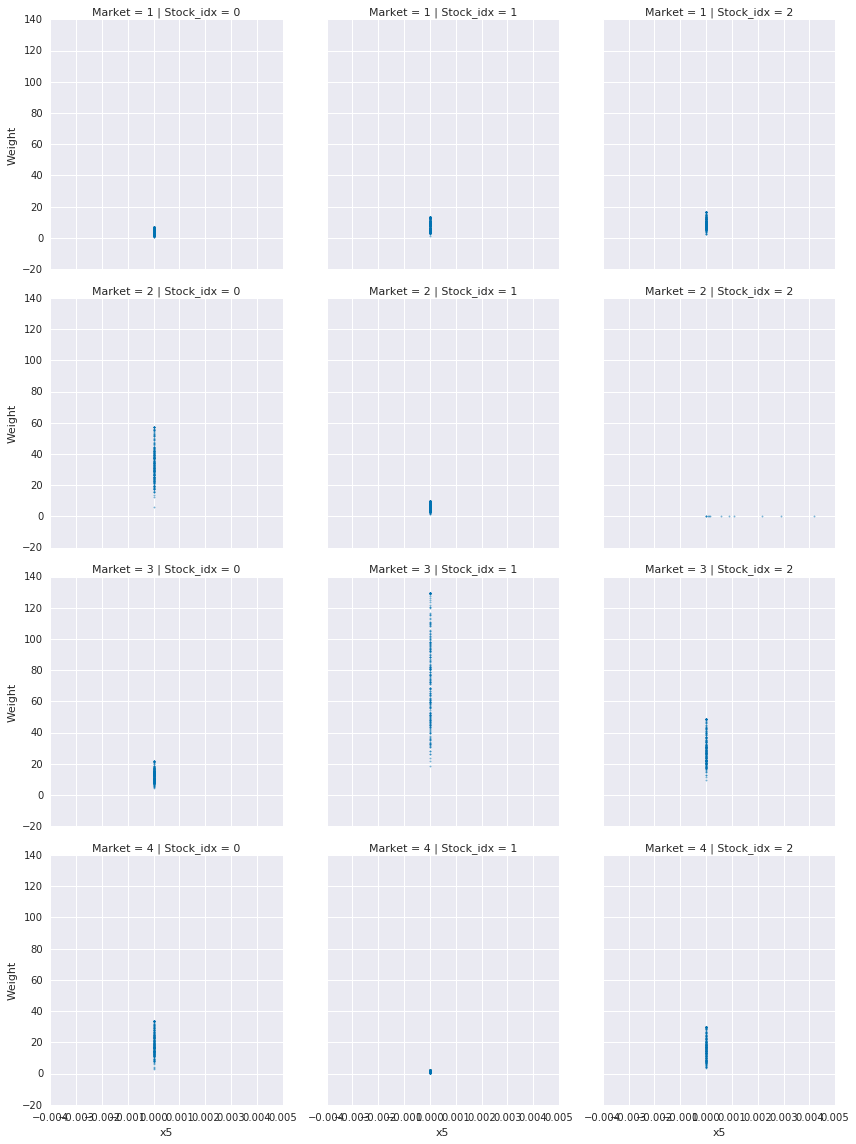

In [100]:
#C = O(MARKET=4, N_SAMPLES=20, COL_WRAP=5, HEIGHT=135, WIDTH=135)
C = O(MARKET=3, N_SAMPLES=3, COL_WRAP=3, HEIGHT=235, WIDTH=235)
C.MKTSTK, C.STOCKS = [], set()
for MARKET in range(1, 5):
    data = df[df.Market == MARKET]
    stocks = random.sample(set(data.Stock), C.N_SAMPLES)
    C.MKTSTK += [stocks]
    C.STOCKS |= set(stocks)
data = df[df.Stock.isin(C.STOCKS)].copy()
def thing(x):
    return C.MKTSTK[int(x.Market) - 1].index(int(x.Stock))
data['Stock_idx'] = data.apply(thing, axis=1)
data['x0 log'] = np.log(data.x0 + 1e14)
g = sns.FacetGrid(data, row='Market', col='Stock_idx', size=4)#, col_wrap=C.COL_WRAP)
g = g.map(plt.scatter, 'x5', 'Weight', s=2, alpha=.5)

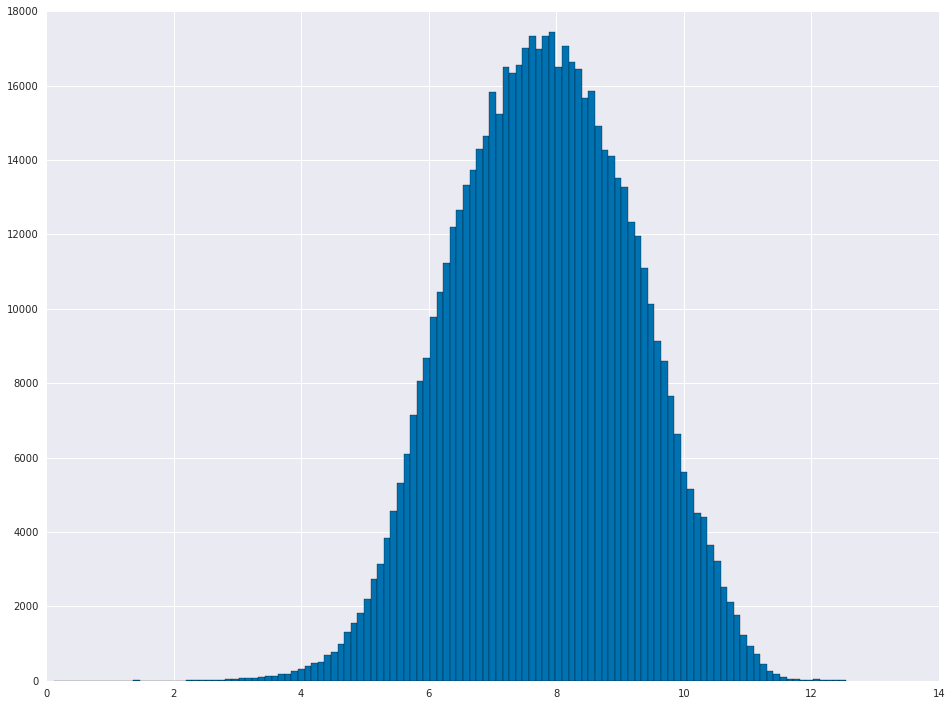

In [29]:
dots = (np.log(W) + 6).values
dots = dots[~np.isnan(dots)]
plt.hist(dots, bins=120);

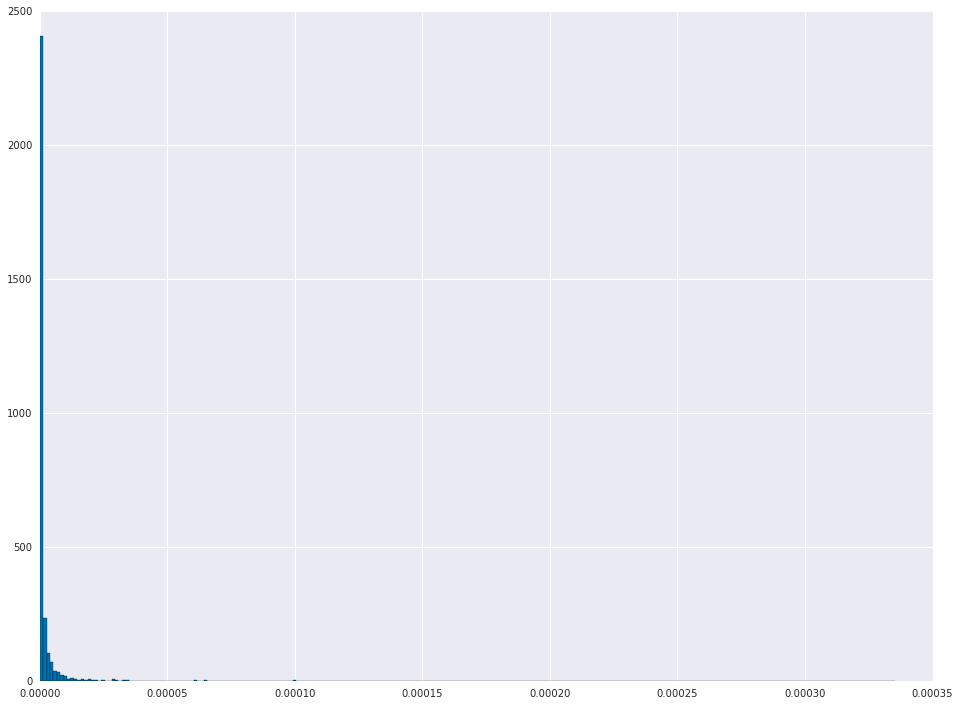

In [320]:
((Y).var()).hist(bins=250);

In [ ]:
from scipy.stats import norm
#norm.ppf

In [20]:
X0.iloc[i:j, :]

Stock,0,1,2,3,4,5,6,7,8,9,...,3013,3014,3015,3016,3017,3018,3019,3020,3021,3022
Day,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,0.007902,0.137830,0.001531,0.000039,1.148923,0.016851,0.030652,0.076488,...,0.125841,0.020843,0.023142,NaN,0.008234,NaN,0.147288,0.003580,0.011098,0.014683
2,0.004891,NaN,0.013916,0.204695,0.007826,0.000004,4.725823,0.007433,0.041327,0.016315,...,0.107998,0.007370,0.015602,NaN,0.001394,NaN,0.142266,0.018358,0.026639,0.000730
5,NaN,NaN,0.001722,0.022385,0.010272,0.000037,2.630712,0.009565,0.030211,0.007744,...,0.149010,0.001577,0.005963,NaN,0.004189,NaN,0.143775,0.041385,0.051385,0.005145
6,0.001582,NaN,0.004063,0.039430,0.001059,0.000036,4.325508,0.005564,0.008257,0.004289,...,0.069550,0.001448,0.018166,NaN,0.005920,NaN,0.748195,0.004182,0.013292,0.003382
7,0.005460,NaN,0.001608,0.008190,0.001694,0.000056,2.412920,0.009003,0.032410,0.021474,...,0.353243,0.002196,0.009386,NaN,0.000816,NaN,0.139272,0.017211,0.017498,0.003816


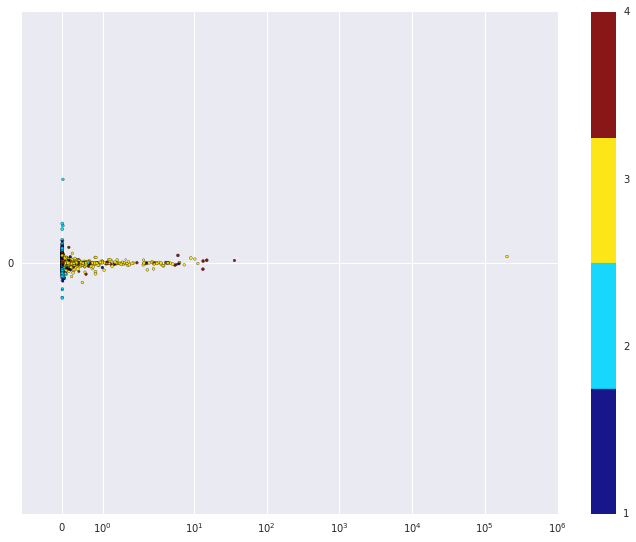

In [28]:
fig, ax = plt.subplots()
i, j = 0, 5
h = ax.scatter(
    X0.iloc[i:j, :],
    Y.iloc[i:j, :],
    s=(np.log(W.iloc[0:2, :]) + 6),
    alpha=.9,
    c=MARKET.iloc[i:j, :],
    cmap=plt.get_cmap('jet', 4)
)
fig.colorbar(h, ticks=[1, 2, 3, 4])
ax.set_xscale('symlog')
ax.set_yscale('symlog')